# Heartsteps Data Transformation

We transform the Heartsteps v1 data to satisfy two primary criterion: (1) alignment of study day and decision slot across users and (2) restructuring of the data to match the distributional nearest neighbors framework. More information about this structure can be found later in the notebook.


In [1]:
import numpy as np

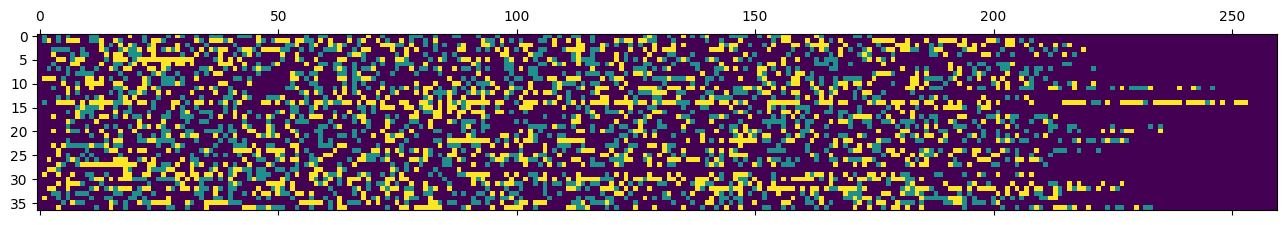

In [ ]:
Data = np.load("out/data.npy", allow_pickle=True)
Mask = np.load("out/mask.npy", allow_pickle=True)

## Import libraries and load data

In [4]:
import pandas as pd
import numpy as np
import os

data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
output_dir = "out"
os.makedirs(output_dir, exist_ok=True)

The `jbsteps.csv` file contains step data for (roughly) every minute that trial partipants were wearing their Jawbone step tracker. We select the columns of interest and index the dataframe by the user index and the time that steps were recorded.

In [150]:
# load in the 5 minute observations
df_steps = pd.read_csv(os.path.join(data_dir, "jbsteps.csv"))
df_steps = df_steps[["user.index", "steps.utime", "steps", "study.day.nogap"]]
df_steps["steps.utime"] = pd.to_datetime(df_steps["steps.utime"])
# creeate multi-index
df_steps = df_steps.set_index(["user.index", "steps.utime"])

The `suggestions.csv` file contains data for each notification slot during all user trials. There are 5 notification slots per day.

In [6]:
df_suggestions = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))

/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_34957/1227668198.py:1: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_suggestions = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))


We select the columns of interest and drop rows containing nan for crucial columns.

In [32]:
df_sugg_sel = df_suggestions[
    [
        "user.index",
        "decision.index.nogap",
        "sugg.select.utime",
        "sugg.decision.utime",
        "sugg.select.slot",
        "avail",
        "send",
        "send.active",
        "send.sedentary",
    ]
]
df_sugg_sel = df_sugg_sel.copy()
df_sugg_sel["sugg.decision.utime"] = pd.to_datetime(df_sugg_sel["sugg.decision.utime"])
df_sugg_sel = df_sugg_sel.dropna(
    subset=["sugg.decision.utime", "sugg.select.utime", "user.index"]
)
df_sugg_sel["sugg.decision.utime"]

0      2015-07-22 16:31:53
1      2015-07-22 18:32:10
2      2015-07-22 21:31:48
3      2015-07-22 23:31:50
4      2015-07-23 09:31:31
               ...        
8269   2016-01-26 00:03:36
8270   2016-01-26 13:01:04
8271   2016-01-26 16:27:50
8272   2016-01-26 19:02:09
8273   2016-01-26 22:27:07
Name: sugg.decision.utime, Length: 8273, dtype: datetime64[ns]

Next, we group the step observations into 5 minute chunks. 

In [33]:
def get_mode(x):
    if len(pd.Series.mode(x) > 1):
        return pd.Series.mode(x, dropna=False)[0]
    else:
        return pd.Series.mode(x, dropna=False)


df_5min = (
    df_steps.groupby(
        [
            pd.Grouper(freq="5min", level="steps.utime", label="right"),
            pd.Grouper(level="user.index"),
        ],
        sort=False,
    )
    .agg({"steps": "sum", "study.day.nogap": lambda x: get_mode(x)})
    .reset_index()
)
df_5min

,steps.utime,user.index,steps,study.day.nogap
0,2015-07-22 14:55:00,1,19,NaN
1,2015-07-22 15:00:00,1,163,NaN
2,2015-07-22 15:05:00,1,58,NaN
3,2015-07-22 15:10:00,1,2,NaN
4,2015-07-22 15:15:00,1,61,NaN
...,...,...,...,...
98524,2016-01-26 21:20:00,37,23,46.0
98525,2016-01-26 21:25:00,37,57,46.0
98526,2016-01-26 21:35:00,37,67,46.0
98527,2016-01-26 21:45:00,37,20,46.0


Now, we expand the time periods to include all times of day, not just the times that steps were measured.
This is necessary as step data collection often occured in spurts. This means that time periods in which a notification was sent may not be represented in the original data frame, making it difficult to merge `df_suggestions` and `df_5min`. Time periods where steps were not tracked are imputed with 0 steps. This may not accurately represent the user's real step count in that period, but it is a limitation imposed by the data. Future work may fold in the Google Steps tracking information, which is more complete but potentially inaccurate approximation of user step activity.

In [41]:
# fill out the 5 minute intervals between measurements
from datetime import timedelta


def reind_id(df_u):
    rng = pd.date_range(
        min(df_u.index.astype("datetime64[ns]")),
        max(df_u.index.astype("datetime64[ns]")) + timedelta(days=1),
        normalize=True,
        inclusive="both",
        freq="5min",
    )
    rng = rng[rng.indexer_between_time("00:00", "23:55")]
    # print(rng)
    df_reind = df_u.reindex(rng)
    df_reind["user.index"] = df_reind["user.index"].ffill().bfill()
    df_reind["study.day.nogap"] = df_reind["study.day.nogap"].bfill().ffill()
    df_reind["steps"] = df_reind["steps"].fillna(0)
    return df_reind


    
df_5min_ind = df_5min.set_index("steps.utime")

# df_expand5min = df_5min_ind.groupby("user.index", group_keys=False).apply(
#     lambda df_u: reind_id(df_u)
# )

# First, extract the unique user.index values before groupby
user_indices = df_5min_ind["user.index"].unique()

# Create an empty list to store the processed dataframes
result_dfs = []

# Process each user separately, without using groupby
for user_idx in user_indices:
    # Filter for just this user
    df_u = df_5min_ind[df_5min_ind["user.index"] == user_idx].copy()
    
    # Apply your reindexing function
    reindexed_df = reind_id(df_u)
    
    # Add to our results
    result_dfs.append(reindexed_df)
df_expand5min = pd.concat(result_dfs)
df_expand5min = df_expand5min.reset_index(names="steps.utime")

df_expand5min["user.index"] = df_expand5min["user.index"].astype("int64")
print(df_expand5min)

               steps.utime  user.index  steps  study.day.nogap
0      2015-07-22 00:00:00           1    0.0              0.0
1      2015-07-22 00:05:00           1    0.0              0.0
2      2015-07-22 00:10:00           1    0.0              0.0
3      2015-07-22 00:15:00           1    0.0              0.0
4      2015-07-22 00:20:00           1    0.0              0.0
...                    ...         ...    ...              ...
492512 2016-01-26 23:40:00          37    0.0             46.0
492513 2016-01-26 23:45:00          37    0.0             46.0
492514 2016-01-26 23:50:00          37    0.0             46.0
492515 2016-01-26 23:55:00          37    0.0             46.0
492516 2016-01-27 00:00:00          37    0.0             46.0

[492517 rows x 4 columns]


Next, we merge `df_sugg_sel` with `df_expand5min`. The merge will provide notification information for each decision slot. Notifications are grouped into the 5 minute block that occurs after the decision was made. For example, a decision made at 8:31:50 AM would be joined with the 8:35 AM time slot. 

In [42]:
# merge as of on steps.utime with the time of each notification time period. by = user.index, tolerance = pd.Timedelta("5min"), check for direction
df_merged = (
    pd.merge_asof(
        df_expand5min.sort_values(by="steps.utime"),
        df_sugg_sel.sort_values(by="sugg.decision.utime"),
        left_on="steps.utime",
        right_on="sugg.decision.utime",
        by="user.index",
        tolerance=pd.Timedelta("5min"),
        allow_exact_matches=False,
        direction="backward",
    )
    .sort_values(by=["user.index", "steps.utime"])
    .reset_index(drop=True)
)

# df_merged[df_merged["user.index"] == 1][df_merged["sugg.select.utime"] == "2015-09-15 10:30:00"]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# display(df_merged[df_merged['user.index'] == 36][7000:7150])

# want to treat vacation days as maximally normal observation periods -> they are not notification periods
df_merged["sugg.select.slot"] = np.where(
    df_merged["decision.index.nogap"].isna(), np.nan, df_merged["sugg.select.slot"]
)
display(df_merged)

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,2015-07-22 00:00:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,2015-07-22 00:05:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 00:10:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 00:15:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 00:20:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
492512,2016-01-26 23:40:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492513,2016-01-26 23:45:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492514,2016-01-26 23:50:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492515,2016-01-26 23:55:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


We take 12 rows after each decision period. This represents 1 hour of step data following each (potential) notification. We drop duplicate rows as some notifications fell within one hour of each other, creating overlapping time ranges. 

In [43]:
df_merged.iloc[
    np.argsort(
        pd.notna(df_merged["sugg.select.slot"]),
    )
]

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,2015-07-22 00:00:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
327071,2015-12-10 13:55:00,25,0.0,15.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
327070,2015-12-10 13:50:00,25,0.0,15.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
327069,2015-12-10 13:45:00,25,40.0,15.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
327068,2015-12-10 13:40:00,25,0.0,15.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
234726,2015-11-07 23:05:00,18,36.0,26.0,130.0,2015-11-07 23:00:00,2015-11-07 23:04:02,4.0,True,False,False,False
436371,2016-01-16 01:35:00,33,19.0,35.0,178.0,2016-01-16 01:30:00,2016-01-16 01:31:37,5.0,True,True,True,False
371824,2015-11-15 23:05:00,28,0.0,24.0,120.0,2015-11-15 23:00:00,2015-11-15 23:01:35,4.0,True,True,True,False
221201,2015-10-24 00:05:00,17,62.0,22.0,112.0,2015-10-24 00:00:00,2015-10-24 00:02:38,5.0,True,True,True,False


In [64]:
df_test = df_merged[df_merged["user.index"] == 1]
print(len(df_test))
print(len(df_test[pd.notna(np.argsort(df_test["sugg.select.slot"]))].index))
idx = df_test.index.get_indexer_for(
        df_test[np.argsort(df_test["sugg.select.slot"])].index
    )

15841
15841


/Users/calebchin/Projects/NearestNeighbors/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/Users/calebchin/Projects/NearestNeighbors/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)


KeyError: "None of [Index([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,\n       ...\n        -1,  -1,  -1,  -1, 173,  -1,  -1,  -1,  -1,  -1],\n      dtype='int64', length=15841)] are in the [columns]"

In [85]:
# grab 12 rows after each notification period
def takeRange(df: pd.DataFrame, range: int):
    idx = df.index.get_indexer_for(
        df[pd.notna(df["sugg.select.slot"])].index
    )
    # valid_mask = pd.notna(df["sugg.select.slot"])

    # # Then, get the sorted indices of those valid rows
    # valid_sorted_indices = df[valid_mask]["sugg.select.slot"].argsort()

    # # Get the original index labels for these sorted positions
    # sorted_index_labels = df[valid_mask].iloc[valid_sorted_indices].index

    # # Finally, get the integer positions of these labels in the original DataFrame
    # idx = df.index.get_indexer_for(sorted_index_labels)
    ranges = [np.arange(i, min(i + range + 1, len(df))) for i in idx]
    # print("Next Df")
    # for i in ranges:
    #  num_overlap = len(df.iloc[i][pd.notna(df['sugg.select.slot'])])
    #  if (num_overlap > 1):
    #   print("Overlap: ")
    #   print(df.iloc[i])
    return df.iloc[np.concatenate(ranges)]

# def takeRange(df: pd.DataFrame, range: int):
#     # Get rows where sugg.select.slot is not NA
#     valid_df = df.dropna(subset=["sugg.select.slot"])
    
#     # Sort by the column value
#     sorted_df = valid_df.sort_values("sugg.select.slot")
    
#     # Get positions of these sorted rows in the original dataframe
#     idx = df.index.get_indexer_for(sorted_df.index)
    
#     # Create ranges around each position
#     ranges = [np.arange(i, min(i + range + 1, len(df))) for i in idx]
    
#     # Return concatenated ranges
#     return df.iloc[np.concatenate(ranges)]


# find ids of the notification period -> this only happens when sugg.select.slot is not na
# idx = df_merged.index.get_indexer_for(df_merged[pd.notna(df_merged['sugg.select.slot'])].index)
# we want 1 hour of data after the notification period, so 12 slots
# df_merged.iloc[np.unique(np.concatenate([np.arange(i, min(i+n+1, len(df_merged)))
# for i in idx]))]

unique_users = df_merged["user.index"].unique()
result_dfs = []

for user_idx in unique_users:
    df_user = df_merged[df_merged["user.index"] == user_idx]
    df_user_range = takeRange(df_user, 12)
    result_dfs.append(df_user_range)

df_merged_cut = pd.concat(result_dfs).reset_index(drop=True)

# # Drop duplicates if needed
# df_merged_cut_nd = df_merged_cut.drop_duplicates()
# df_merged_cut = (
#     df_merged.groupby("user.index", group_keys=False)
#     .apply(lambda df_u: takeRange(df_u, 12))
#     .reset_index(drop=True)
# )
df_merged_cut_nd = df_merged_cut.drop_duplicates()

# set up column for study day
df_merged_cut_nd = df_merged_cut_nd.copy()
df_merged_cut_nd["study_day"] = np.nan
df_merged_cut_nd["new_slot"] = np.nan

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# df_merged_cut.groupby('user.index').apply(lambda df_u: df_u.index)
df_merged_cut_nd
#df_merged_cut

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
0,2015-07-22 16:35:00,1,0.0,0.0,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2.0,True,True,False,True,NaN,NaN
1,2015-07-22 16:40:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 16:45:00,1,212.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 16:50:00,1,278.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 16:55:00,1,478.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100722,2016-01-26 23:10:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100723,2016-01-26 23:15:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100724,2016-01-26 23:20:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100725,2016-01-26 23:25:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_merged_cut_nd[df_merged_cut_nd["user.index"] == 1].iloc[0:250])

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
0,2015-07-22 00:00:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-22 00:05:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 00:10:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 00:15:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 00:20:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-07-22 00:25:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-07-22 00:30:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-07-22 00:35:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-07-22 00:40:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-07-22 00:45:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We artificially "fix" the decision slots and study day columns. The adjustments done below counteract abnormalities in the data, such as a notification scheduled to sent at slot 4 but was instead sent at slot 1. The need for a new study day column arises from mismatches in time between recorded steps and the notifications. Since study days were only measured explicitly alongside recorded steps, the notifications would often have the incorrect study day if multiple notifications were sent before any steps were recorded. To reduce these study day miscalculations, we manually create new decision slots based on the existing patterns and base study days entirely on a sequence of 5 decision slots. 

In [88]:
def create_slots(df):
    most_rec_slot = 0.0
    for ind, row in df.iterrows():
        curr_slot = row["sugg.select.slot"]
        if not np.isnan(curr_slot):
            if (
                most_rec_slot != 5.0
                and curr_slot != most_rec_slot + 1
                and most_rec_slot != 0.0
            ):
                df.at[ind, "new_slot"] = most_rec_slot + 1
                most_rec_slot += 1
            elif most_rec_slot == 5.0 and curr_slot != 1:
                df.at[ind, "new_slot"] = 1
                most_rec_slot = 1
            else:
                df.at[ind, "new_slot"] = curr_slot
                most_rec_slot = curr_slot
            # print(curr_study_day)
            # df.at[ind,'study_day'] = curr_study_day
            # print(df.loc[ind]['study_day'])
    return df


def study_day(df):
    most_rec_slot = 1.0
    curr_study_day = 1
    for ind, row in df.iterrows():
        curr_slot = row["new_slot"]
        if not np.isnan(curr_slot):
            if most_rec_slot == 5.0 and curr_slot == 1:
                curr_study_day += 1
            most_rec_slot = curr_slot
            # print(curr_study_day)
            df.at[ind, "study_day"] = curr_study_day

    return df


# df_slot = df_merged_cut_nd.groupby("user.index", group_keys=False).apply(
#     lambda df_u: create_slots(df_u)
# )
# df_study_day = df_slot.groupby("user.index", group_keys=False).apply(
#     lambda df_u: study_day(df_u)
# )

unique_users = df_merged_cut_nd["user.index"].unique()
slot_results = []

for user_idx in unique_users:
    df_user = df_merged_cut_nd[df_merged_cut_nd["user.index"] == user_idx]
    user_slots = create_slots(df_user)
    slot_results.append(user_slots)

df_slot = pd.concat(slot_results)

# Second groupby operation: study_day
unique_users_slot = df_slot["user.index"].unique()
study_day_results = []

for user_idx in unique_users_slot:
    df_user = df_slot[df_slot["user.index"] == user_idx]
    user_study_day = study_day(df_user)
    study_day_results.append(user_study_day)

df_study_day = pd.concat(study_day_results)

df_study_day

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
0,2015-07-22 16:35:00,1,0.0,0.0,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2.0,True,True,False,True,1.0,2.0
1,2015-07-22 16:40:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 16:45:00,1,212.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 16:50:00,1,278.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 16:55:00,1,478.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100722,2016-01-26 23:10:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100723,2016-01-26 23:15:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100724,2016-01-26 23:20:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100725,2016-01-26 23:25:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_slot

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
0,2015-07-22 00:00:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-22 00:05:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 00:10:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 00:15:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 00:20:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399704,2016-01-26 23:40:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399717,2016-01-26 23:45:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399730,2016-01-26 23:50:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399743,2016-01-26 23:55:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_slot[
    (df_slot["sugg.select.slot"] != df_slot["new_slot"]) & pd.notna(df_slot["avail"])
]

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
80131,2015-08-12 10:35:00,1,52.0,20.0,NaN,2015-08-12 10:30:00,2015-08-12 10:31:23,NaN,True,True,False,True,NaN,NaN
81067,2015-08-12 16:35:00,1,52.0,20.0,NaN,2015-08-12 16:30:00,2015-08-12 16:32:06,NaN,True,True,False,True,NaN,NaN
81379,2015-08-12 18:35:00,1,0.0,20.0,NaN,2015-08-12 18:30:00,2015-08-12 18:32:07,NaN,True,True,True,False,NaN,NaN
81847,2015-08-12 21:35:00,1,0.0,20.0,NaN,2015-08-12 21:30:00,2015-08-12 21:31:08,NaN,False,False,False,False,NaN,NaN
82159,2015-08-12 23:35:00,1,0.0,20.0,NaN,2015-08-12 23:30:00,2015-08-12 23:30:56,NaN,True,True,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5242587,2016-01-08 19:45:00,31,0.0,5.0,NaN,2016-01-08 19:40:00,2016-01-08 19:41:30,NaN,False,NaN,False,False,NaN,NaN
5243029,2016-01-08 22:35:00,31,50.0,5.0,NaN,2016-01-08 22:30:00,2016-01-08 22:31:30,NaN,False,NaN,False,False,NaN,NaN
5243263,2016-01-09 00:05:00,31,137.0,5.0,NaN,2016-01-09 00:00:00,2016-01-09 00:01:47,NaN,True,False,False,False,NaN,NaN
6091656,2015-12-28 16:35:00,36,0.0,15.0,74.0,2015-12-28 16:30:00,2015-12-28 16:31:30,2.0,False,NaN,False,False,NaN,1.0


In [15]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        df_study_day[
            (df_study_day["user.index"] == 1) & (pd.notna(df_study_day["avail"]))
        ]
    )

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary,study_day,new_slot
2443,2015-07-22 16:35:00,1,0.0,0.0,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2.0,True,True,False,True,1.0,2.0
2755,2015-07-22 18:35:00,1,142.0,0.0,1.0,2015-07-22 18:30:00,2015-07-22 18:32:10,3.0,True,True,True,False,1.0,3.0
3223,2015-07-22 21:35:00,1,70.0,0.0,2.0,2015-07-22 21:30:00,2015-07-22 21:31:48,4.0,True,False,False,False,1.0,4.0
3535,2015-07-22 23:35:00,1,195.0,0.0,3.0,2015-07-22 23:30:00,2015-07-22 23:31:50,5.0,True,True,False,True,1.0,5.0
5095,2015-07-23 09:35:00,1,0.0,1.0,4.0,2015-07-23 09:30:00,2015-07-23 09:31:31,1.0,True,False,False,False,2.0,1.0
6187,2015-07-23 16:35:00,1,204.0,1.0,5.0,2015-07-23 16:30:00,2015-07-23 16:33:51,2.0,True,True,False,True,2.0,2.0
6499,2015-07-23 18:35:00,1,184.0,1.0,6.0,2015-07-23 18:30:00,2015-07-23 18:31:07,3.0,True,True,True,False,2.0,3.0
6967,2015-07-23 21:35:00,1,412.0,1.0,7.0,2015-07-23 21:30:00,2015-07-23 21:31:16,4.0,True,True,True,False,2.0,4.0
7279,2015-07-23 23:35:00,1,0.0,1.0,8.0,2015-07-23 23:30:00,2015-07-23 23:32:54,5.0,True,False,False,False,2.0,5.0
8839,2015-07-24 09:35:00,1,0.0,2.0,9.0,2015-07-24 09:30:00,2015-07-24 09:31:49,1.0,True,False,False,False,3.0,1.0


We find the maximum study day so that we can pad the remaining trials to that study period. We also set the index of the final data frame as a combination of the user index, study day, and the decision slot of the day. In theory, this index is unique. 

In [89]:
# find the max study day
print(max(df_study_day["study.day.nogap"]))
print(df_study_day["study_day"].max())

# print(max_study_day)
df_final = df_study_day.set_index(["user.index", "study_day", "new_slot"])

51.0
52.0


In `transform_dnn`, we iteratively search for the set of measurements for each user x study day x day decision slot combination. If such a measurement exists, the missingness of the data is determined by whether or not a notification was sent. If it does not, the missingness could either be treated as the user not being available (A = 2) or the data not being observed (A = 0). Further, we only use `send.sedentary` as an indicator of treatment. Future work could combine `send.sedentary` and `send.active`. TODO: several questions here

In [146]:
import pandas as pd
import warnings

def transform_dnn(df, users=37, max_study_day=52, day_dec=5, num_measurements=12):
    """ """
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    final_M = np.zeros((users, max_study_day, day_dec, num_measurements))
    final_A = np.zeros((users, max_study_day, day_dec))
    # df_sorted = df.copy()
    # df_sorted.index = pd.MultiIndex.from_tuples(df.index, names=df.index.names)
    #df_sorted = df.sort_index().copy()
    #print(df_sorted.index.lexsort_depth)
    for user in range(1, users + 1):
        for day in range(1, max_study_day + 1):
            for slot in range(1, day_dec + 1):
                try:
                    df_uds = df.loc[pd.IndexSlice[(user, day, slot)]]
                    ind = df.index.get_indexer_for(df_uds.index)[0]
                    # if len(ind) > 1:
                    #     print(ind)
                    #     display(df.iloc[ind])
                    df_rng = df.iloc[
                        np.arange(ind, min(ind + num_measurements, len(df)))
                    ]
                    if df.iloc[ind]["avail"]:
                        # only take send.sedentary as the treatment indicator, could use send.active later
                        val = df.iloc[ind]["send.sedentary"]
                        conv_val = val if ~np.isnan(val) else df.iloc[ind]["send"]
                        final_A[user - 1, day - 1, slot - 1] = int(conv_val)
                    else:
                        final_A[user - 1, day - 1, slot - 1] = 2

                    measurements = df_rng["steps"].to_numpy()
                    if len(measurements) == num_measurements:
                        final_M[user - 1, day - 1, slot - 1] = measurements
                    else:
                        m_pad = np.pad(
                            measurements,
                            (0, num_measurements - len(measurements)),
                            constant_values=np.nan,
                        )
                        final_M[user - 1, day - 1, slot - 1] = m_pad
                except KeyError as e:
                    # this user is missing the study day/day ind
                    #print(repr(e))
                    final_A[user - 1, day - 1, slot - 1] = (
                        0  # do we consider missing data as not observed or not available
                    )
                    final_M[user - 1, day - 1, slot - 1] = np.full(
                        num_measurements, np.nan
                    )
    final_M = final_M.reshape((users, max_study_day * day_dec, num_measurements))
    final_A = final_A.reshape((users, max_study_day * day_dec))
    return final_M, final_A

In [143]:
df_final[~df_final.index.duplicated(keep="first")]

steps.utime  steps  study.day.nogap  \
user.index study_day new_slot                                               
1          1.0       2.0      2015-07-22 16:35:00    0.0              0.0   
           NaN       NaN      2015-07-22 16:40:00    0.0              0.0   
           1.0       3.0      2015-07-22 18:35:00  142.0              0.0   
                     4.0      2015-07-22 21:35:00   70.0              0.0   
                     5.0      2015-07-22 23:35:00  195.0              0.0   
...                                           ...    ...              ...   
37         46.0      5.0      2016-01-26 00:05:00   40.0             45.0   
           47.0      1.0      2016-01-26 13:05:00    0.0             46.0   
                     2.0      2016-01-26 16:30:00    0.0             46.0   
                     3.0      2016-01-26 19:05:00    0.0             46.0   
                     4.0      2016-01-26 22:30:00    0.0             46.0   

                               decision.index.nogap    sugg.select.utime  \
user.index study_day new_slot                                              
1          1.0       2.0                        0.0  2015-07-22 16:30:00   
           NaN       NaN                        NaN                  NaN   
           1.0       3.0                        1.0  2015-07-22 18:30:00   
                     4.0                        2.0  2015-07-22 21:30:00   
                     5.0                        3.0  2015-07-22 23:30:00   
...                                             ...                  ...   
37         46.0      5.0                      225.0  2016-01-26 00:02:00   
           47.0      1.0                      226.0  2016-01-26 13:00:00   
                     2.0                      227.0  2016-01-26 16:26:00   
                     3.0                      228.0  2016-01-26 19:00:00   
                     4.0                      229.0  2016-01-26 22:25:00   

                              sugg.decision.utime  sugg.select.slot  avail  \
user.index study_day new_slot                                                
1          1.0       2.0      2015-07-22 16:31:53               2.0   True   
           NaN       NaN                      NaT               NaN    NaN   
           1.0       3.0      2015-07-22 18:32:10               3.0   True   
                     4.0      2015-07-22 21:31:48               4.0   True   
                     5.0      2015-07-22 23:31:50               5.0   True   
...                                           ...               ...    ...   
37         46.0      5.0      2016-01-26 00:03:36               5.0   True   
           47.0      1.0      2016-01-26 13:01:04               1.0  False   
                     2.0      2016-01-26 16:27:50               2.0   True   
                     3.0      2016-01-26 19:02:09               3.0   True   
                     4.0      2016-01-26 22:27:07               4.0   True   

                                send send.active send.sedentary  
user.index study_day new_slot                                    
1          1.0       2.0        True       False           True  
           NaN       NaN         NaN         NaN            NaN  
           1.0       3.0        True        True          False  
                     4.0       False       False          False  
                     5.0        True       False           True  
...                              ...         ...            ...  
37         46.0      5.0       False       False          False  
           47.0      1.0       False       False          False  
                     2.0        True        True          False  
                     3.0        True       False           True  
                     4.0        True       False           True  

[7786 rows x 11 columns]

Finally, we transform the data and show the masking matrix to see the missingness pattern.

In [107]:
df_final

steps.utime  steps  study.day.nogap  \
user.index study_day new_slot                                               
1          1.0       2.0      2015-07-22 16:35:00    0.0              0.0   
           NaN       NaN      2015-07-22 16:40:00    0.0              0.0   
                     NaN      2015-07-22 16:45:00  212.0              0.0   
                     NaN      2015-07-22 16:50:00  278.0              0.0   
                     NaN      2015-07-22 16:55:00  478.0              0.0   
...                                           ...    ...              ...   
37         NaN       NaN      2016-01-26 23:10:00    0.0             46.0   
                     NaN      2016-01-26 23:15:00    0.0             46.0   
                     NaN      2016-01-26 23:20:00    0.0             46.0   
                     NaN      2016-01-26 23:25:00    0.0             46.0   
                     NaN      2016-01-26 23:30:00    0.0             46.0   

                               decision.index.nogap    sugg.select.utime  \
user.index study_day new_slot                                              
1          1.0       2.0                        0.0  2015-07-22 16:30:00   
           NaN       NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
...                                             ...                  ...   
37         NaN       NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   
                     NaN                        NaN                  NaN   

                              sugg.decision.utime  sugg.select.slot avail  \
user.index study_day new_slot                                               
1          1.0       2.0      2015-07-22 16:31:53               2.0  True   
           NaN       NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
...                                           ...               ...   ...   
37         NaN       NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   
                     NaN                      NaT               NaN   NaN   

                               send send.active send.sedentary  
user.index study_day new_slot                                   
1          1.0       2.0       True       False           True  
           NaN       NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
...                             ...         ...            ...  
37         NaN       NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  
                     NaN        NaN         NaN            NaN  

[100658 rows x 11 columns]

In [147]:
# df_final.loc[1, 20, 1.0]
M_hs, A_hs = transform_dnn(df_final)

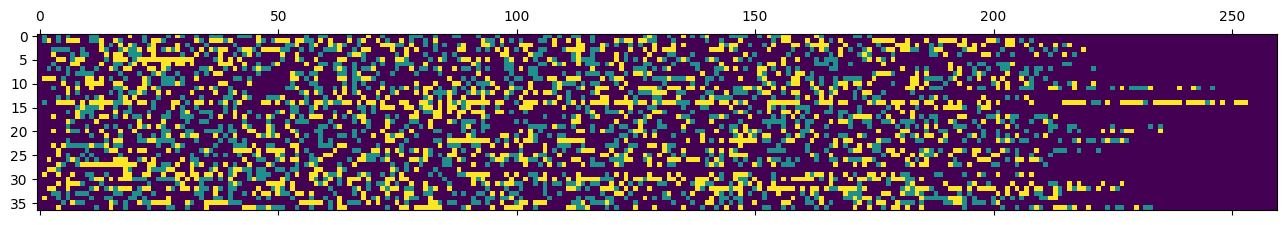

In [148]:
from matplotlib.pyplot import matshow

matshow(A_hs, aspect="auto")

In [149]:
M_hs.shape

(37, 260, 12)

In [ ]:
np.save(os.path.join(output_dir, "heartsteps_mask.npy"), A_hs)
np.save(os.path.join(output_dir, "heartsteps_data.npy"), M_hs)